In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import matplotlib
import scipy.stats as stats
import scipy.stats
from scipy.special import boxcox, inv_boxcox


def ccc(array1, array2):
    sigx = np.std(array1)
    sigy = np.std(array2)
    corr = np.corrcoef(array1, array2)[0][1]
    mux = np.mean(array1)
    muy = np.mean(array2)
    return (2*corr*sigx*sigy) / (sigx**2 + sigy**2 + (mux - muy)**2)



# VGG 2d - LOSO - HOG


In [7]:
root = 'jsons/splits_adapted_hog1em4lr//'

In [8]:
predicted_arousals = []
actual_arousals = []
predicted_valence = []
actual_valence = []

for file in os.listdir(root):
    if "pth" not in file:
        print(file)
        with open (os.path.join(root, file)) as f:
            data = json.load(f)

            predicted_arousals  = data['predicted_arousal'] + predicted_arousals
            actual_arousals  = data['actual_arousal'] + actual_arousals

            predicted_valence  = data['predicted_valence'] + predicted_valence
            actual_valence  = data['actual_valence'] + actual_valence


20.json
36.json
16.json
6.json
7.json
17.json
40.json
37.json
21.json
10.json
26.json
30.json
31.json
27.json
1.json
11.json
2.json
12.json
32.json
25.json
33.json
13.json
29.json
3.json
34.json
22.json
18.json
38.json
4.json
14.json
15.json
5.json
39.json
19.json
23.json
9.json
35.json


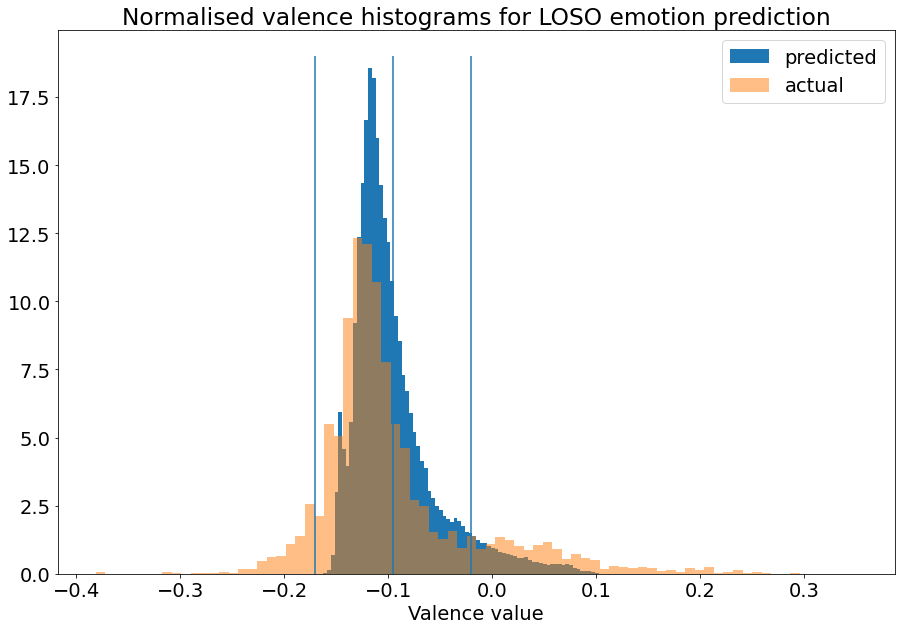

In [104]:
fig, ax = plt.subplots(figsize=(15,10))
matplotlib.rcParams.update({'font.size': 19.5})

plt.hist(predicted_arousals, bins=80, label='predicted', density=True)
plt.hist(actual_arousals, bins=80, alpha= 0.5, label='actual', density=True)
plt.xlabel("Valence value")
# plt.vlines(np.mean(predicted_valence), 0, 30, linestyles ="dotted", colors ="k") 
# plt.vlines(np.mean(actual_valence), 0, 30, linestyles ="dotted", colors ="r") 
plt.legend()
plt.title(f"Normalised valence histograms for LOSO emotion prediction")
plt.vlines(actual_arousals.mean(), 0, 19)
plt.vlines(actual_arousals.mean() - actual_arousals.std(), 0, 19)
plt.vlines(actual_arousals.mean() + actual_arousals.std(), 0, 19)
plt.show()

# plots for tracking

In [43]:
cd jsons/splits/

/Users/williamrichards/Desktop/jsons/splits


In [44]:
import torch
from amigosnet.existing_model.models.vgg_face import *
import cv2
from torchvision import datasets, transforms

In [52]:
net = FERNet()
net = nn.DataParallel(net)
pretrained_weights = torch.load("0_model.pth", map_location=torch.device('cpu'))
net.load_state_dict(pretrained_weights)
net = net.eval()

In [53]:
means = (0.0, 0.0, 0.0)
stds = (255.0, 255.0, 255.0)

loader = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(means, stds),
            ])

def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = cv2.imread(image_name)
    image = loader(image.astype(np.double)).float()
    image = torch.tensor(image)
    image = image.unsqueeze(0)  
    return image  


In [54]:
targets = pd.read_csv('../../amigosnet/targets.csv', index_col = [0,1])
part, vid = 1 , 4

xs = []
ys = []
max_frame = 0
for file in os.listdir("../../datasets/Amigossmall"):
    if file[0:len(f"{part},{vid}")] == f'{part},{vid}':
        max_frame = max(max_frame, int(file.split(",")[-1].split(".")[0]))
        xs.append (int(file.split(',')[3].split('.')[0])/25)
        image = image_loader(f'../../datasets/Amigossmall/{file}')
        res = net(image)
        ys.append(res)
print (max_frame )
print (max_frame / 25)

/Users/williamrichards/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


2286
91.44


In [55]:
segment = max_frame // (20*25)


remainder =  (
    len(np.linspace(0, int(max(xs))+1, int(max(xs))+1)) -
    len(np.repeat(targets.loc[(part, vid), 'arousal'].values[:segment +1][:-1], 20))

)
remainder

In [ ]:
labels_arousal_seconds = np.linspace(0, int(max(xs))+1, int(max(xs))+1)
labels_arousal = np.append(
    np.repeat(targets.loc[(part, vid), 'arousal'].values[:segment +1][:-1], 20),
    np.repeat(targets.loc[(part, vid), 'arousal'].values[:segment +1][-1:], remainder)
)            

labels_valence_seconds = np.linspace(0, int(max(xs))+1, int(max(xs))+1)
labels_valence = np.append(
    np.repeat(targets.loc[(part, vid), 'valence'].values[:segment +1][:-1], 20),
    np.repeat(targets.loc[(part, vid), 'valence'].values[:segment +1][-1:], remainder)
)

In [ ]:
labels_arousal.shape , labels_arousal_seconds.shape

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))

plt.plot(labels_arousal_seconds, labels_arousal, label = 'Average External Annotation arousal', c='r')
plt.plot(labels_valence_seconds, labels_valence, label = 'Average External Annotation valence')

valence = [x.tolist()[0][1] for x in ys]
arousal = [x.tolist()[0][0] for x in ys]

s1 = plt.scatter(xs, arousal, s=8, c='k', label='Predicted Arousal')
s2 = plt.scatter(xs, valence, s=8, c='g', label='Predicted Valence')
lgnd = plt.legend(loc=2, fontsize=14)
lgnd.legendHandles[0]._legmarker.set_markersize(16.5)
lgnd.legendHandles[1]._legmarker.set_markersize(16.5)

plt.title("Emotion reproduction against time for Participant 1 video 4")
plt.xlabel('Timestep (s)')
plt.ylabel('Emotion')
# plt.xlim(-3, 86)
plt.savefig('reproduction_affectnet_no_augmentation.jpg')
plt.show()

